#### Imports and Helpers

In [115]:
from IPython.display import Image
from IPython.core.display import HTML 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use("default")
font = {'family' : 'Times New Roman',
        'size'   : 20}
plt.rc('font', **font)

def groupby_bar_plot(*groups, group_names=["Clean BERT", "Corrupted BERT"], 
                     groupby_names=["Negative", "Positive", "Neutral"], 
                     title="None"):
    x = np.arange(len(groupby_names))  # the label
    width = 0.35  # the width of the bars
    
    
    fig, ax = plt.subplots(figsize=(6,5))
    rects1 = ax.bar(x - width/2, groups[0], width, label=group_names[0], edgecolor='blue', color="green")
    rects2 = ax.bar(x + width/2, groups[1], width, label=group_names[1], edgecolor='blue', color="red")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('F1')
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),
          ncol=2, fancybox=True, shadow=True, fontsize=15)
    

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.title(title, fontsize=15, pad=10)
    
    plt.ylim(0,1)
    plt.show()

### Experiments

**Experiments 0**: Sanity Checks with Trained Models!

In [ ]:
# Load a model

**Experiments 1**: WikiText15M Pretrained Models

Potential Hypothesis: A BERT model, pretrained with corrupted text data (i.e., destroying all world knowledge), has transferrable skills to a downstream non-corrupted English classification task.

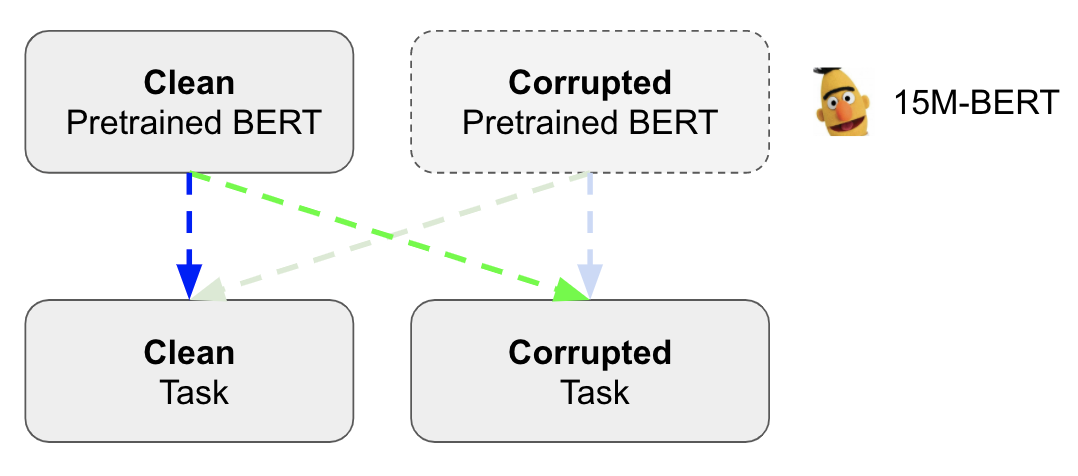

In [2]:
Image(filename = "../data_files/exp1.png", width=600)

**Experiments 1.1**: Non-Crossway Performance Checks

In [118]:
exp_data = pd.read_csv("../data_files/15M-pretrain.csv", delimiter=",")
exp_data

,samples,sst-3-mF1,sst-3-cF1,corrupted-sst-3-mF1,corrupted-sst-3-cF1,cross-sst-3-mF1,cross-sst-3-cF1,cross-corrupted-sst-3-mF1,cross-corrupted-sst-3-cF1,cross-finetune-sst-3-mF1,cross-finetune-sst-3-cF1
0,100.00%,0.60616,"0.75393,0.76874,0.29582",0.61664,"0.75109,0.77219,0.32665",0.5811,"0.72241,0.72417,0.29670",0.57918,"0.72377,0.73583,0.27795",0.54825,"0.69483,0.73255,0.21739"


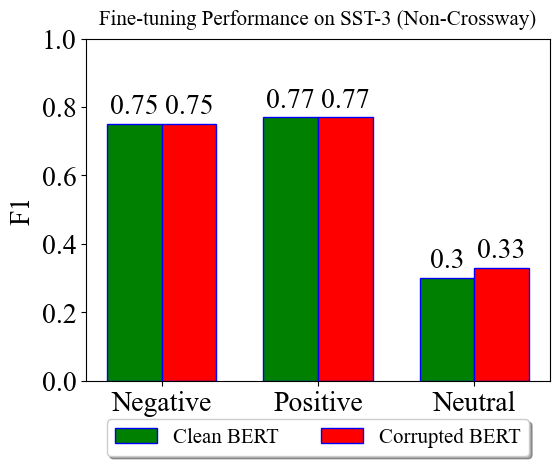

In [119]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data["sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data["corrupted-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (Non-Crossway)")

**Experiments 1.2**: Crossway Performance Evaluations

E.g., clean BERT is fine-tuned on corrupted data.

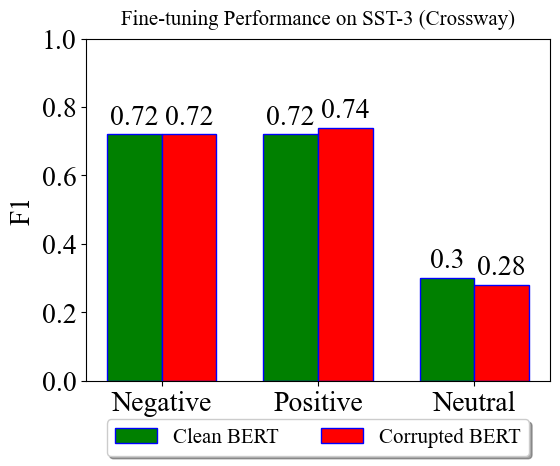

In [123]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data["cross-sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data["cross-corrupted-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (Crossway)")

**Discussion 1**: We see that the transfer learning performance from corrupted world to the a English downstream task maintains in the same level as from the English world to a English downstream task, with slight drops in performance. The **Transferrability** part is still confounded with other factors: (1) What if it is just that our pretrained model with 15M tokens is not big enough to hold world knowledge? So, what we are seeing here is not world knowledge transfer, but plain better initializations / training from scratch performance?

**Experiments 2**: 3B Pretrained BERT

The discussion above leads to our second set of experiments. What if we study this with pretrained BERT with 3B tokens (i.e., Google-BERT - bert-uncased-base model).

Potential Hypothesis: Fully trained BERT model with 3B English token will be harder to transfer to corrupted world. With larger learning rate, performance may increase as it is trying to forget old world knowledge, and do the context switching.

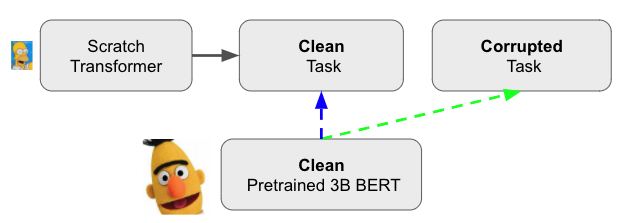

In [127]:
Image(filename = "../data_files/exp2.png", width=600)

**Experiments 2.1**: Performance Check

In [130]:
exp_data_1 = pd.read_csv("../data_files/3B-pretrain.csv", delimiter=",")
exp_data_1

,learning_rate,samples,sst-3-mF1,sst-3-cF1,cross-sst-3-mF1,cross-sst-3-cF1,cross-finetune-sst-3-mF1,cross-finetune-sst-3-cF1
0,0.00002,100.00%,0.68932,"0.81757,0.83510,0.41530",0.52032,"0.65212,0.70884,0.20000",0.55512,"0.69029,0.73858,0.23649"
1,0.00004,100.00%,0.72359,"0.83488,0.84952,0.48635",0.56938,"0.67788,0.73798,0.29226",0.59826,"0.70755,0.76763,0.31959"
2,0.00006,100.00%,0.71602,"0.83886,0.84430,0.46489",0.58421,"0.72629,0.73978,0.28655",0.62948,"0.74344,0.76451,0.38049"
3,0.00008,100.00%,0.71539,"0.83164,0.84479,0.46973",0.60348,"0.73220,0.75221,0.32603",0.63857,"0.76557,0.77513,0.37500"
4,0.00010,100.00%,0.71589,"0.83314,0.84449,0.47002",0.61598,"0.70762,0.76645,0.37387",0.62936,"0.73772,0.76259,0.38776"
5,0.00040,100.00%,0.67396,"0.80457,0.81730,0.40000",0.11446,"0.00000,0.00000,0.34337",0.43030,"0.51680,0.63178,0.14232"
6,0.00080,100.00%,0.11446,"0.00000,0.00000,0.34337",0.11446,"0.00000,0.00000,0.34337",0.11446,"0.00000,0.00000,0.34337"


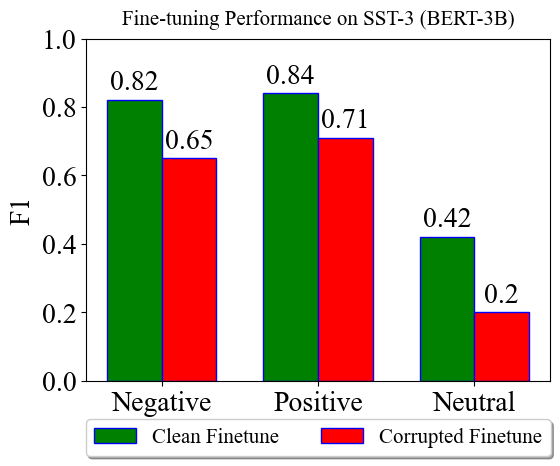

In [132]:
clean_to_clean = [round(float(f_s),2) for f_s in exp_data_1["sst-3-cF1"].values[0].split(",")]
corrupted_to_corrupted = [round(float(f_s),2) for f_s in exp_data_1["cross-sst-3-cF1"].values[0].split(",")]
groupby_bar_plot(clean_to_clean, corrupted_to_corrupted, title="Fine-tuning Performance on SST-3 (BERT-3B)" ,
                 group_names=["Clean Finetune", "Corrupted Finetune"])

In [158]:
def curve_plot(*data_stream, title="None", 
               stream_name=["clean_finetune", "corrupted_finetune", "twice_finetune"], 
               baseline_f1=None):
    
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    plt.style.use('ggplot')
    plt.style.use("default")
    font = {'family' : 'Times New Roman',
            'size'   : 20}
    plt.rc('font', **font)
    
    fig, ax = plt.subplots(figsize=(6,5))

    x_labels = ["2e-5", "4e-5", "6e-5", "8e-5", "1e-4", "4e-4", "8e-4"]
    x_ticks = [i for i in range(0, 7)]
    y_labels = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8"]
    y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    plt.plot(x_ticks, data_stream[0], "--", label='clean_finetune', linewidth=5.0, marker="o", markersize=15)
    plt.plot(x_ticks, data_stream[1], "--", label='corrupted_finetune', linewidth=5.0, marker="^", markersize=15)
    plt.plot(x_ticks, data_stream[2], "--", label='twice_finetune', linewidth=5.0, marker="s", markersize=15)
    if baseline_f1:
        plt.plot(x_ticks, [baseline_f1 for _ in range(len(data_stream[0]))], 
                 label='baseline', linewidth=2.0, marker="D", markersize=10, alpha=0.3)
    plt.grid(True)
    plt.grid(color='grey', linestyle='-.')
    plt.xticks(x_ticks, x_labels, fontsize=20)
    plt.yticks(y_ticks, y_labels, fontsize=20)
    plt.tight_layout()
    plt.ylim(0.4, 0.8)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, fancybox=True, shadow=True)
    plt.xlabel("Initial Learning Rate")
    plt.ylabel("F1")
    plt.show()

**Experiments 2.2**: Learning Rate Effect

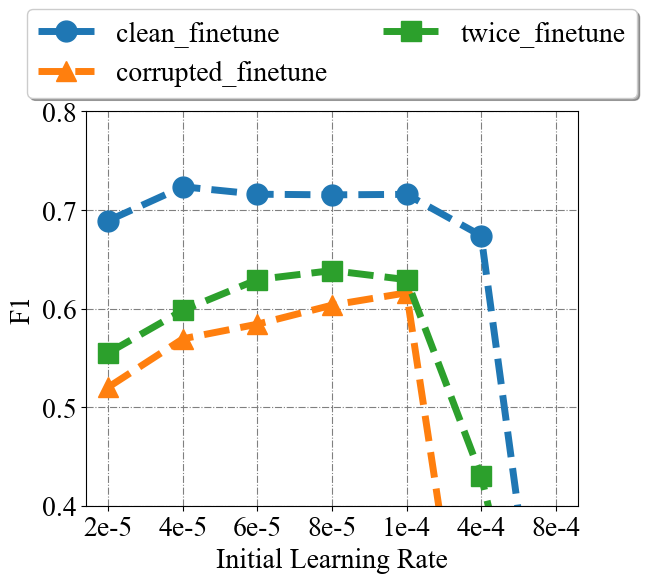

In [159]:
clean_finetune = [v for v in exp_data_1["sst-3-mF1"].values]
corrupted_finetune = [v for v in exp_data_1["cross-sst-3-mF1"].values]
twice_finetune = [v for v in exp_data_1["cross-finetune-sst-3-mF1"].values]

transformer_baseline = pd.read_csv("../data_files/transformer-baseline.csv", delimiter=",")
curve_plot(clean_finetune, corrupted_finetune, twice_finetune, title="Performance and Learning Rate")

**Experiments 2.3**: A Strong Baseline (Transformer from scratch)

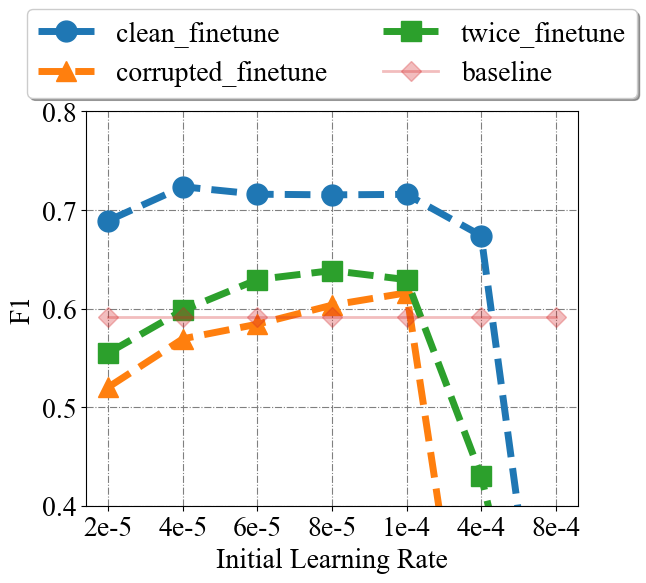

In [160]:
curve_plot(clean_finetune, corrupted_finetune, twice_finetune, title="Performance and Learning Rate", 
           baseline_f1=transformer_baseline["sst-3-mF1"].values[0])

**Discussion 2**: Higher learning rate is causing the BERT to intentially forget learnt world knowledge, which makes it easier to transfer to a totally corrupted English world.

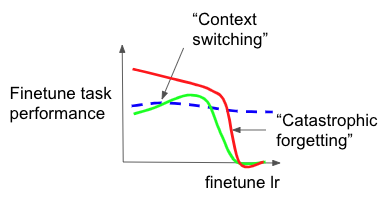

In [161]:
Image(filename = "../data_files/exp3.png", width=600)